# Modelo de classificação kNN
Neste arquivo vamos criar um modelo kNN e otimizar seus hiperparâmetros para fazer previsões do estado de saúde dos pacientes a partir de seus biomarcadores. O dataframe escolhido para este estudo tem uma coluna denominada Class, que guarda o estado do indivíduo, entre Control e Impaired. Os indivíduos classificados como Control são indivíduos de controle saudáveis, enquanto Impaired são indivíduos afetados por Alzheimer.

In [23]:
# Bibliotecas
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [15]:
# Importando dados
features = pd.read_csv("Features para trino.csv")
features = features.drop("Unnamed: 0", axis=1)

target = pd.read_csv("Target para treino.csv")
target = target["Class"]
features = features.values

X_teste = pd.read_csv("Features para teste.csv")
X_teste = X_teste.drop("Unnamed: 0", axis=1)
y_teste = pd.read_csv("Target para teste.csv")["Class"]

In [16]:
#Normalizando o target:
le = LabelEncoder()
nle = LabelEncoder()
target = le.fit_transform(target)
y_teste = nle.fit_transform(y_teste)

In [17]:
# Selecionando features
from sklearn.feature_selection import SequentialFeatureSelector

modelo = KNeighborsClassifier()
seletor = SequentialFeatureSelector(
    modelo,
    n_features_to_select="auto",
    direction="backward",
    scoring="recall",
    cv = 5,
)

seletor.fit(features, target)

X_treino_modificado = seletor.transform(features)
X_teste_modificado = seletor.transform(X_teste)

print(f"Número original de atributos: {seletor.n_features_in_}")
print(f"Número de atributos selecionados: {seletor.n_features_to_select_}")
print(f"Colunas selecionadas: {seletor.support_}")

Número original de atributos: 134
Número de atributos selecionados: 67
Colunas selecionadas: [False False False False False False False  True False False False False
 False  True False False False  True False False False False  True  True
 False False False  True False False  True False False False False False
 False False False  True False False  True False False False False False
 False False  True False False False False False False False  True  True
 False False False  True  True False  True False  True  True False False
  True False False False  True False  True False  True False False  True
  True False  True  True  True False  True  True  True  True False  True
  True  True False  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


C:\Users\vitor25023\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SequentialFeatureSelector was fitted without feature names
  warnings.warn(


In [18]:
# Preparando a otimização de hiperparâmetros com optuna
#Criando as funções auxiliares
def instancia_geral(trial, parametros, algoritmo):
    modelo = algoritmo(**parametros)
    return modelo

def objetivo_geral(trial, parametros, algoritmo):
    modelo = instancia_geral(trial, parametros, algoritmo)
    metricas = cross_val_score(
        modelo,
        features,
        target,
        scoring="recall",
        cv= 5
    )
    return metricas.mean()


def funcao_objetivo_parcial_knn(trial):
    parametros = {"n_neighbors": trial.suggest_int("n_neighbors", 2, 100),
                  "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
                  "p": trial.suggest_int("p", 1, 2)}
    return objetivo_geral(trial, parametros, KNeighborsClassifier)

In [19]:
NOME_DO_ESTUDO = "knn"
estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

estudo_knn.optimize(funcao_objetivo_parcial_knn, n_trials=1000)

[I 2025-11-01 15:31:17,805] Using an existing study with name 'knn' instead of creating a new one.
[I 2025-11-01 15:31:18,311] Trial 1000 finished with value: 0.32087912087912085 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 0.32087912087912085.
[I 2025-11-01 15:31:18,528] Trial 1001 finished with value: 0.1923076923076923 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 0.32087912087912085.
[I 2025-11-01 15:31:18,756] Trial 1002 finished with value: 0.32087912087912085 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 0.32087912087912085.
[I 2025-11-01 15:31:18,971] Trial 1003 finished with value: 0.27582417582417584 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 1}. Best is trial 10 with value: 0.32087912087912085.
[I 2025-11-01 15:31:19,206] Trial 1004 finished with value: 0.29230769230769227 and parameters: {'n_neighbors': 5,

In [20]:
# Treinando um modelo k-NN com estes parâmetros
params = estudo_knn.best_trial.params

predictor = KNeighborsClassifier(**params)
predictor.fit(X_treino_modificado, target)

,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [21]:
predictor = KNeighborsClassifier(**params)
predictor.fit(X_treino_modificado, target)
y_pred = predictor.predict(X_teste_modificado)
accuracy = accuracy_score(y_teste, y_pred)
print(accuracy)

y_pred_trans = le.inverse_transform(y_pred)

medida = cross_val_score(predictor, X_teste_modificado, y_teste, scoring="recall", cv=5)
print("Recall médio no conjunto de teste:", medida.mean())

0.6904761904761905
Recall médio no conjunto de teste: 0.21000000000000002


['Control' 'Impaired']


<Axes: >

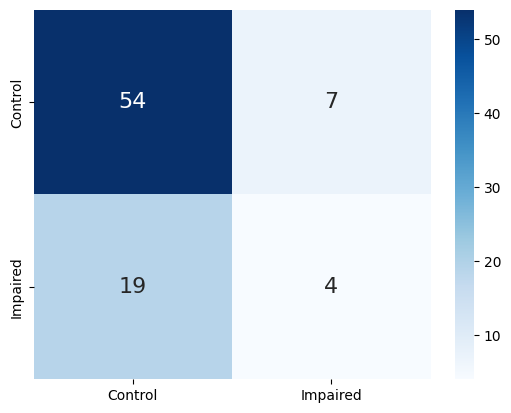

In [22]:
#Montando a matriz de confusão 
classes = np.unique(y_pred_trans)
Y = nle.inverse_transform(y_teste)
print(classes)
cm = confusion_matrix(Y, y_pred_trans, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, cmap="Blues")

In [24]:
print(classification_report(Y, y_pred_trans))

              precision    recall  f1-score   support

     Control       0.74      0.89      0.81        61
    Impaired       0.36      0.17      0.24        23

    accuracy                           0.69        84
   macro avg       0.55      0.53      0.52        84
weighted avg       0.64      0.69      0.65        84



## Conclusões:
Nosso modelo apresenta grande viés para classificar indivíduos como saudáveis. Apesar de ter acertado a maioria dos indivíduos saudáveis, classificou a maior parte dos doentes como saudáveis, apresentando um falso negativo muito forte. Isso pode acontecer porque o modelo k-NN é suscetível à qualidade dos vizinhos, e como em nossos dados de treino, a quantidade de indivíduos saudáveis é maior que a de doentes, muito provavelmente, nosso modelo foi enviezado para esta categoria. A razão entre a quantidade de acertos na previsão de pessoas doentes e a quantidade real de pessoas doentes é menor que um terço, o que torna nosso modelo insatisfatório.